In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
#import pingouin as pg
#import researchpy

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

Autosaving every 30 seconds


In [2]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("network.xlsx"), index_col=0)
df.head()

,CLUSTER,NETWORK,PARTICIPANT,CONDITION,DURATION,GENDER,AGE,AMERICAN,PARTY,TWITTERUSER,...,round7,round8,round9,round10,round11,round12,round13,round14,round15,round16
Response ID,,,,,,,,,,,,,,,,,,,,,
R_2xRSW7gQOO8Aenr,1,1,1,1,2140,1,19,0,3,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R_1g5V0U7NatFob0x,1,1,2,1,2514,0,20,0,4,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R_3iwBoUcO1237jF1,1,1,3,1,2428,1,19,1,1,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R_1QoMZGGj8soR7JL,1,1,4,1,2365,0,20,1,1,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R_3R2sjtnUIGMT7o5,1,1,5,1,2329,0,18,1,2,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "AGE"]
party = df.loc[:, "PARTY"]
twitter = df.loc[:, "TWITTERUSER"]
trust = df.loc[:,"TRUSTSCIENCE"]
duration = df.loc[:,"DURATION"]
network = df.loc[:,"NETWORK"]
participant = df.loc[:,"PARTICIPANT"]

In [4]:
# Extract data with df.loc[:,"datastart":"dataend"]
RdeltaB = df.loc[:, "RU1":"RU16"]
convincing = df.loc[:, "C1":"C16"]
rigorous = df.loc[:, "R1":"R16"]
personal = df.loc[:, "P1":"P16"]
widespread = df.loc[:, "W1":"W16"]
share = df.loc[:, "S1":"S16"]
time = df.loc[:, "T1":"T16"]
selfM = df.loc[:, "selfM1":"selfM16"]
jointM = df.loc[:, "jointM1":"jointM16"]
partnerM = df.loc[:, "partnerM1":"partnerM16"]
selfB = df.loc[:, "selfB1":"selfB16"]
jointB = df.loc[:, "jointB1":"jointB16"]
partnerB = df.loc[:, "partnerB1":"partnerB16"]
pre = df.loc[:, "PRE1":"PRE16"]
post = df.loc[:, "POST1":"POST16"]
notM = df.loc[:, "notM1":"notM16"]
convround = df.loc[:, "round1":"round16"]


key = [[0,1,2,3,0,1,2,3,4,4,4,4,4,4,4,4],
       [1,2,3,0,1,2,3,0,4,4,4,4,4,4,4,4],
       [2,3,0,1,2,3,0,1,4,4,4,4,4,4,4,4],
       [3,0,1,2,3,0,1,2,4,4,4,4,4,4,4,4]]
ticklbl = ["Anec, Pop","Anec, Unpop","Sci, Pop","Sci, Unpop","Base"]

cond = np.array([key[i-1] for i in df["CONDITION"]])
sz = RdeltaB.shape
partnum = np.arange(sz[0])
itemnum = np.arange(sz[-1])

# This code below is equivalent to the list comprehension above:
#temp = []
#for i in df["CONDITION"]:
#    temp += [key[i-1]]

In [5]:
#create a list of names for the column headers
names = ["RdeltaB", "convincing", "rigorous", "personal", "widespread", "share", "time", "selfM", "partnerM", "jointM", "selfB", "partnerB", "jointB","pre","post","notM", "convround", "cond", "itemnum", \
         "age", "party", "twitter", "trust", "partnum", "duration", "network", "participant"]

#make all the participantXitem variables the same size with numpy arrays broadcast function
data_packed = np.broadcast_arrays(RdeltaB, convincing, rigorous, personal, widespread, share, time, selfM, partnerM, jointM, selfB, partnerB, jointB, pre, post, notM, convround, cond, itemnum)

#make all the participant variables the same size with a similar function to boradcast
cols = [np.tile(a, (sz[1],1)).T for a in [age, party, twitter, trust, partnum, duration, network, participant]]

#append cols to data_packed
data_packed += cols

#take all this and shape it into long format
data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T

#make it a dataframe with the names created above
DATA = pd.DataFrame(data=data_unpacked, columns=names)

nparticipant = int(DATA["partnum"].max())+1
#compute and insert low-moderate-high quantization of belief@pre
lmh_all = []
lmh = [0]*5 + [1]*6 + [2]*5
for p in range(nparticipant):
    idx = np.argsort(DATA.loc[DATA["partnum"]==p, "pre"])
    lmh_sorted = [x for _, x in sorted(zip(idx, lmh))]
    lmh_all += lmh_sorted
DATA.insert(14, "LMH", lmh_all)

#tag rational increases, decreases, baselines
idb = [0]*4 + [1]*4 + [2]*8
idb *= nparticipant
DATA.insert(17, "incdec", idb)

#tag evidence vs baseline
evbase = [0]*8 + [1]*8
evbase *= nparticipant
DATA.insert(1, "evbase", evbase)

In [6]:
DATA.head()

,RdeltaB,evbase,convincing,rigorous,personal,widespread,share,time,selfM,partnerM,...,cond,itemnum,age,party,twitter,trust,partnum,duration,network,participant
0,-30.0,0,69.0,55.0,87.0,55.0,28.0,28.413,0.0,0.0,...,0.0,0.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
1,-1.0,0,37.0,60.0,68.0,38.0,33.0,32.326,0.0,0.0,...,1.0,1.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
2,-9.0,0,70.0,55.0,54.0,72.0,38.0,34.916,0.0,0.0,...,2.0,2.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
3,7.0,0,7.0,9.0,17.0,27.0,0.0,34.315,0.0,0.0,...,3.0,3.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0
4,-8.0,0,77.0,56.0,97.0,80.0,64.0,31.454,0.0,0.0,...,0.0,4.0,19.0,3.0,1.0,81.0,0.0,2140.0,1.0,1.0


## Network convergence v1: Change in (rank) correlation from pre to post

In [7]:
nbin = 20
clustered = np.array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], dtype=np.int)

## PRE
corrs_pre = list()
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "PRE1":"PRE8"])
    corrs_pre += [stats.spearmanr(net.T).correlation]
corrs_pre = np.stack(corrs_pre, axis=0)
## POST
corrs_post = list()
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "POST1":"POST8"])
    corrs_post += [stats.spearmanr(net.T).correlation]
corrs_post = np.stack(corrs_post, axis=0)

## POST-PRE
cdiff = (corrs_post - corrs_pre) / 2
cdiff_clustered = np.mean(cdiff[clustered==1,:,:], axis=0)
cdiff_nonclustered = np.mean(cdiff[clustered==0,:,:], axis=0)

## Hypothesis matrices
H_clustered = np.array(
    [[0,1,1,1,2,3,4,4,5,5],
     [1,0,1,1,2,3,4,4,5,5],
     [1,1,0,2,1,2,3,3,4,4],
     [1,1,2,0,1,2,3,3,4,4],
     [2,2,1,1,0,1,2,2,3,3],
     [3,3,2,2,1,0,1,1,2,2],
     [4,4,3,3,2,1,0,2,1,1],
     [4,4,3,3,2,1,2,0,1,1],
     [5,5,4,4,3,2,1,1,0,1],
     [5,5,4,4,3,2,1,1,1,0]])
H_nonclustered = np.array(
    [[0,2,1,1,2,3,2,2,1,3],
     [2,0,1,1,2,3,2,2,3,1],
     [1,1,0,2,1,2,3,3,2,2],
     [1,1,2,0,1,2,3,3,2,2],
     [2,2,1,1,0,1,2,2,3,3],
     [3,3,2,2,1,0,1,1,2,2],
     [2,2,3,3,2,1,0,2,1,1],
     [2,2,3,3,2,1,2,0,1,1],
     [1,3,2,2,3,2,1,1,0,2],
     [3,1,2,2,3,2,1,1,2,0]])
H_clustered_legal = np.array(
    [[0,1,1,1,2,3,np.nan,4,np.nan,5],
     [1,0,1,1,2,3,4,np.nan,5,np.nan],
     [1,1,0,2,1,2,np.nan,3,np.nan,4],
     [1,1,2,0,1,2,3,np.nan,4,np.nan],
     [2,2,1,1,0,1,2,2,3,3],
     [3,3,2,2,1,0,1,1,2,2],
     [np.nan,4,np.nan,3,2,1,0,2,1,1],
     [4,np.nan,3,np.nan,2,1,2,0,1,1],
     [np.nan,5,np.nan,4,3,2,1,1,0,1],
     [5,np.nan,4,np.nan,3,2,1,1,1,0]]
)
H_nonclustered_legal = np.array(
    [[0,2,1,1,2,3,2,4,1,5],
     [2,0,1,1,2,3,4,np.nan,5,1],
     [1,1,0,2,1,2,np.nan,3,np.nan,4],
     [1,1,2,0,1,2,3,np.nan,4,2],
     [2,2,1,1,0,1,2,2,3,3],
     [3,3,2,2,1,0,1,1,2,2],
     [2,4,np.nan,3,2,1,0,2,1,1],
     [4,np.nan,3,np.nan,2,1,2,0,1,1],
     [1,5,np.nan,4,3,2,1,1,0,2],
     [5,1,4,2,3,2,1,1,2,0]]
)
iu = np.triu_indices(H_clustered.shape[0], 1)
iu_cl = tuple(ind[np.logical_not(np.isnan(H_clustered_legal[iu]))] for ind in iu)
iu_nl = tuple(ind[np.logical_not(np.isnan(H_nonclustered_legal[iu]))] for ind in iu)

<IPython.core.display.Javascript object>


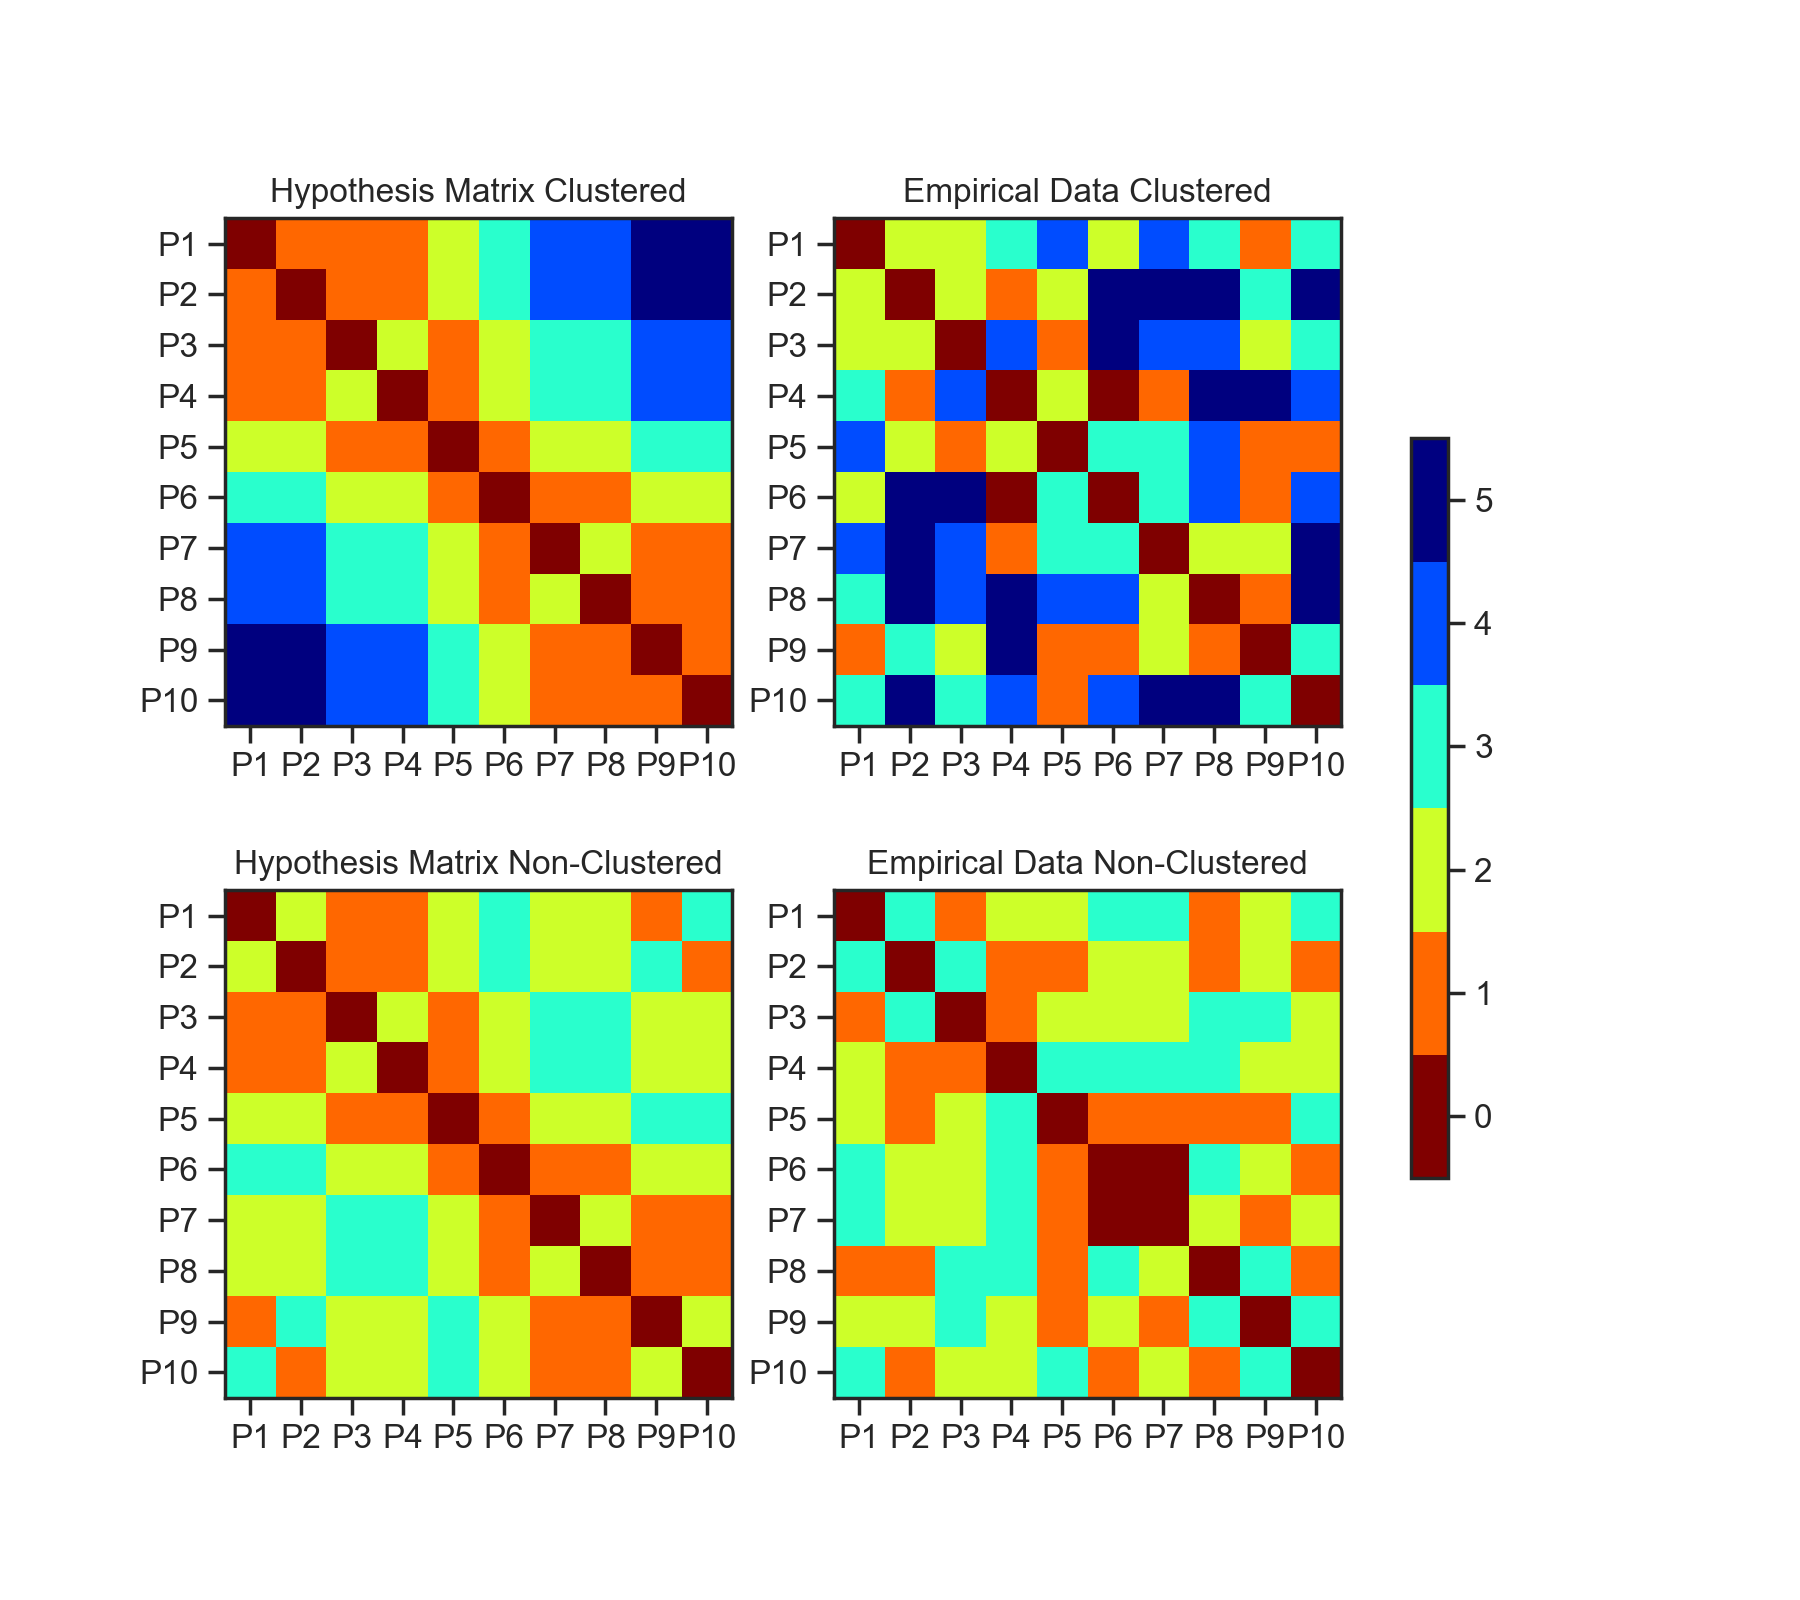

In [8]:
fig, ax = plt.subplots(2,2, figsize=(9,8))
ax[0,0].imshow(H_clustered, cmap="jet_r", clim=[0,5])
ax[0,0].grid(b=None, which='minor', axis='both')
ax[0,0].set_xticks(np.arange(0,10,1)); ax[0,0].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,0].set_yticks(np.arange(0,10,1)); ax[0,0].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,0].set_title("Hypothesis Matrix Clustered")

avcdiff_clustered = cdiff_clustered #.mean(axis=0)
cdiff_clustered_forplotting = np.digitize(avcdiff_clustered, np.quantile(avcdiff_clustered[iu], np.linspace(1,0,6)))
cdiff_clustered_forplotting -= int(cdiff_clustered_forplotting[0,0])*np.eye(cdiff_clustered_forplotting.shape[0], dtype=np.int)
ax[0,1].imshow(cdiff_clustered_forplotting, cmap="jet_r", clim=[0,5])
ax[0,1].set_xticks(np.arange(0,10,1)); ax[1,0].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,1].set_yticks(np.arange(0,10,1)); ax[1,0].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[0,1].set_title("Empirical Data Clustered")

ax[1,0].imshow(H_nonclustered, cmap="jet_r", clim=[0,5])
ax[1,0].grid(b=None, which='minor', axis='both')
ax[1,0].set_xticks(np.arange(0,10,1)); ax[0,1].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,0].set_yticks(np.arange(0,10,1)); ax[0,1].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,0].set_title("Hypothesis Matrix Non-Clustered")

avcdiff_nonclustered = cdiff_nonclustered #.mean(axis=0)
cdiff_nonclustered_forplotting = np.digitize(avcdiff_nonclustered, np.quantile(avcdiff_nonclustered[iu], np.linspace(1,0,4)))
cdiff_nonclustered_forplotting -= int(cdiff_nonclustered_forplotting[0,0])*np.eye(cdiff_nonclustered_forplotting.shape[0], dtype=np.int)
color_map = ax[1,1].imshow(cdiff_nonclustered_forplotting, cmap="jet_r", clim=[0,5])
ax[1,1].set_xticks(np.arange(0,10,1)); ax[1,1].set_xticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,1].set_yticks(np.arange(0,10,1)); ax[1,1].set_yticklabels(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']);
ax[1,1].set_title("Empirical Data Non-Clustered")

color_map.set_cmap(plt.get_cmap("jet_r", 6))
cbar = fig.colorbar(color_map, ax=ax, shrink=0.6, ticks=5*np.linspace(1/12, 11/12, 6))
cbar.ax.set_yticklabels(range(6)) ;

In [12]:
d = 3
N = 10
def random_network(d=3, N=10):
    ## Generate random d-regular graph on N nodes
    G = nx.random_regular_graph(d, N)
    ## Get shortest path between all pairs of nodes
    path = np.array([len(nx.dijkstra_path(G, i, j))-1 for i in range(1,N) for j in range(i)])
    ## Insert into matrix of shortest paths
    D = np.zeros((N,N))
    D[np.tril_indices(N, -1)] = path
    D += D.T
    return D
## Visualize graph with labeled nodes
# plt.figure()
# pos = nx.spring_layout(G)
# nx.draw(G, pos=pos)
# nx.draw_networkx_labels(G, pos=pos)

def full_bootstrap(conv, Htrue, iu, NBOOT=10000):
    r_boot = np.zeros(NBOOT)
    for i in range(NBOOT):
        try:
            H = random_network()
            map_dict = {i+1: q for i,q in enumerate(np.nanquantile(conv[iu], np.linspace(0,1,np.nanmax(H).astype(np.int))))}
            map_dict[0] = np.nan
            mapper = np.vectorize(lambda x: np.nan if np.isnan(x) else map_dict[x])
            sim = mapper(H)
#             r_boot[i] = stats.pearsonr(sim[iu], conv[iu])[0]
            r_boot[i] = stats.spearmanr(sim[iu], conv[iu])[0]
        except:
            i -= 1

    map_dict = {i+1: q for i,q in enumerate(np.nanquantile(conv[iu], np.linspace(0,1,np.nanmax(Htrue).astype(np.int))))}
    map_dict[0] = np.nan
    mapper = np.vectorize(lambda x: np.nan if np.isnan(x) else map_dict[x])
    sim = mapper(Htrue)
#     r_obs = stats.pearsonr(sim[iu], conv[iu])[0]
    r_obs = stats.spearmanr(sim[iu], conv[iu])[0]
    p = np.sum(np.less(r_boot, r_obs)) / NBOOT
    return p, r_obs, r_boot

**Full hypothesis matrices, all connections**

<IPython.core.display.Javascript object>


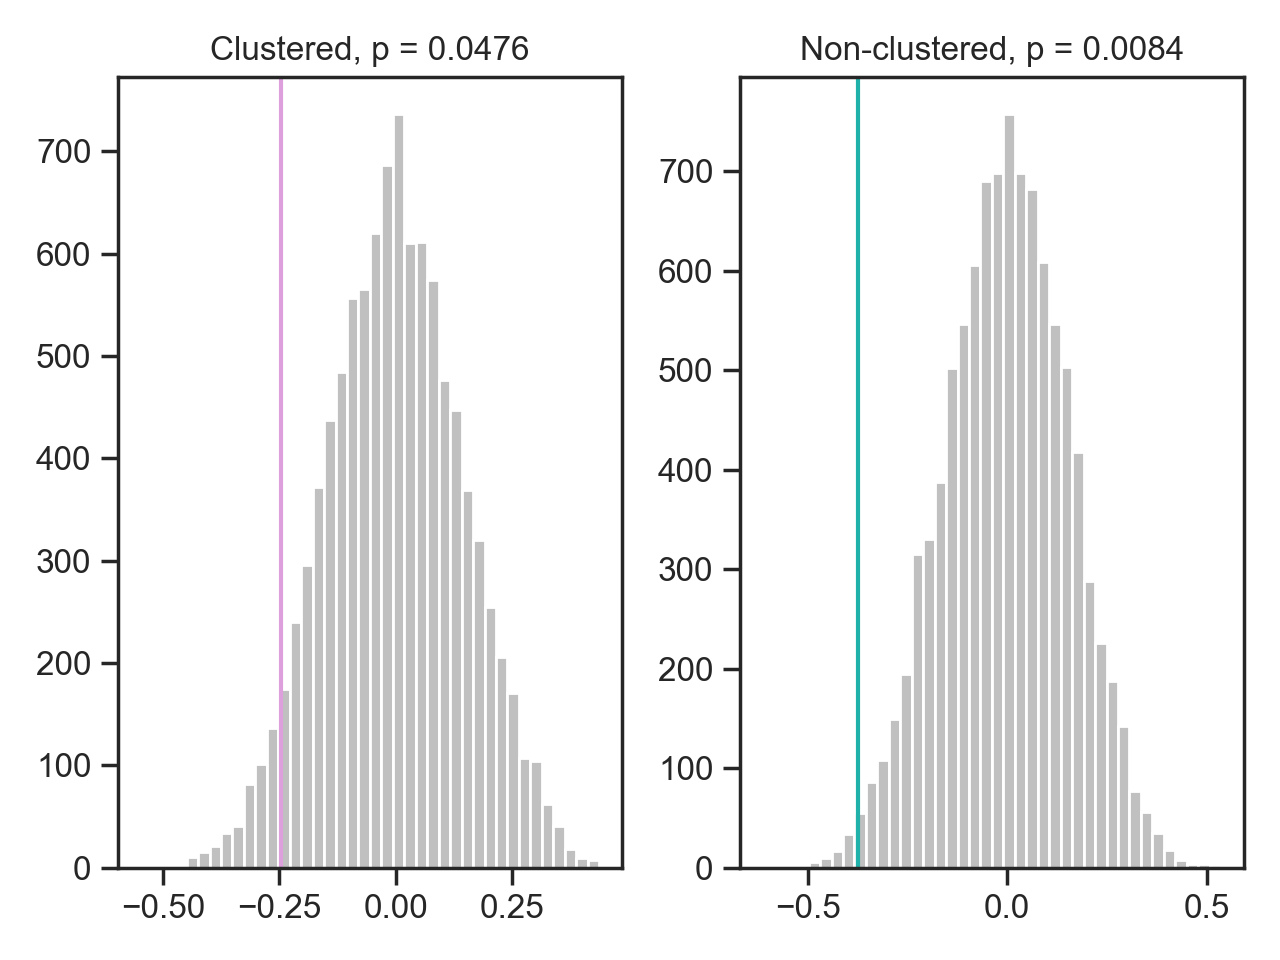

In [13]:
clustered    = full_bootstrap(cdiff_clustered, H_clustered, iu) #, NBOOT=2000)
nonclustered = full_bootstrap(cdiff_nonclustered, H_nonclustered, iu) #, NBOOT=2000)

fig, ax = plt.subplots(1,2)

ax[0].hist(clustered[-1], bins=40, color="#c0c0c0")
ax[0].axvline(clustered[1], color="#DDA0DD")
ax[0].set_title("Clustered, p = %.4f" % clustered[0])

ax[1].hist(nonclustered[-1], bins=40, color="#c0c0c0")
ax[1].axvline(nonclustered[1], color="#20B2AA")
ax[1].set_title("Non-clustered, p = %.4f" % nonclustered[0])

plt.tight_layout()
#plt.savefig('hist.tif', dpi=300, format="tiff")

**Partial hypothesis matrices, "valid" connections only**

_By reviewer request_. Given the sequential conversations, information can't propagate "backwards" in time, such that participant 7 can't send information that would eventually reach participant 3.

<IPython.core.display.Javascript object>


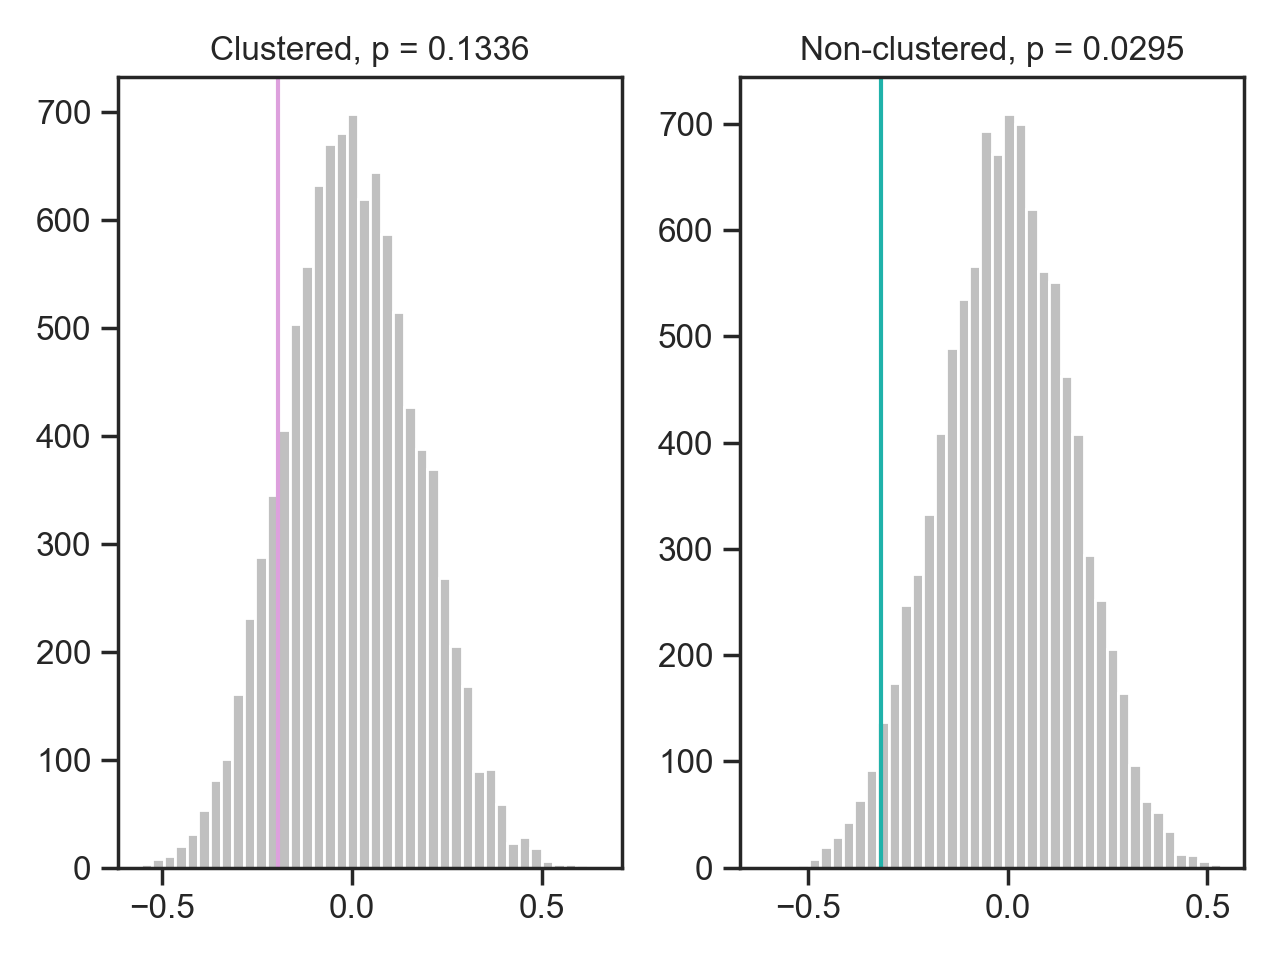

In [14]:
clustered    = full_bootstrap(cdiff_clustered, H_clustered_legal, iu_cl) #, NBOOT=2000)
nonclustered = full_bootstrap(cdiff_nonclustered, H_nonclustered_legal, iu_nl) #, NBOOT=2000)

fig, ax = plt.subplots(1,2)

ax[0].hist(clustered[-1], bins=40, color="#c0c0c0")
ax[0].axvline(clustered[1], color="#DDA0DD")
ax[0].set_title("Clustered, p = %.4f" % clustered[0])

ax[1].hist(nonclustered[-1], bins=40, color="#c0c0c0")
ax[1].axvline(nonclustered[1], color="#20B2AA")
ax[1].set_title("Non-clustered, p = %.4f" % nonclustered[0])

plt.tight_layout()
#plt.savefig('hist.tif', dpi=300, format="tiff")

<IPython.core.display.Javascript object>


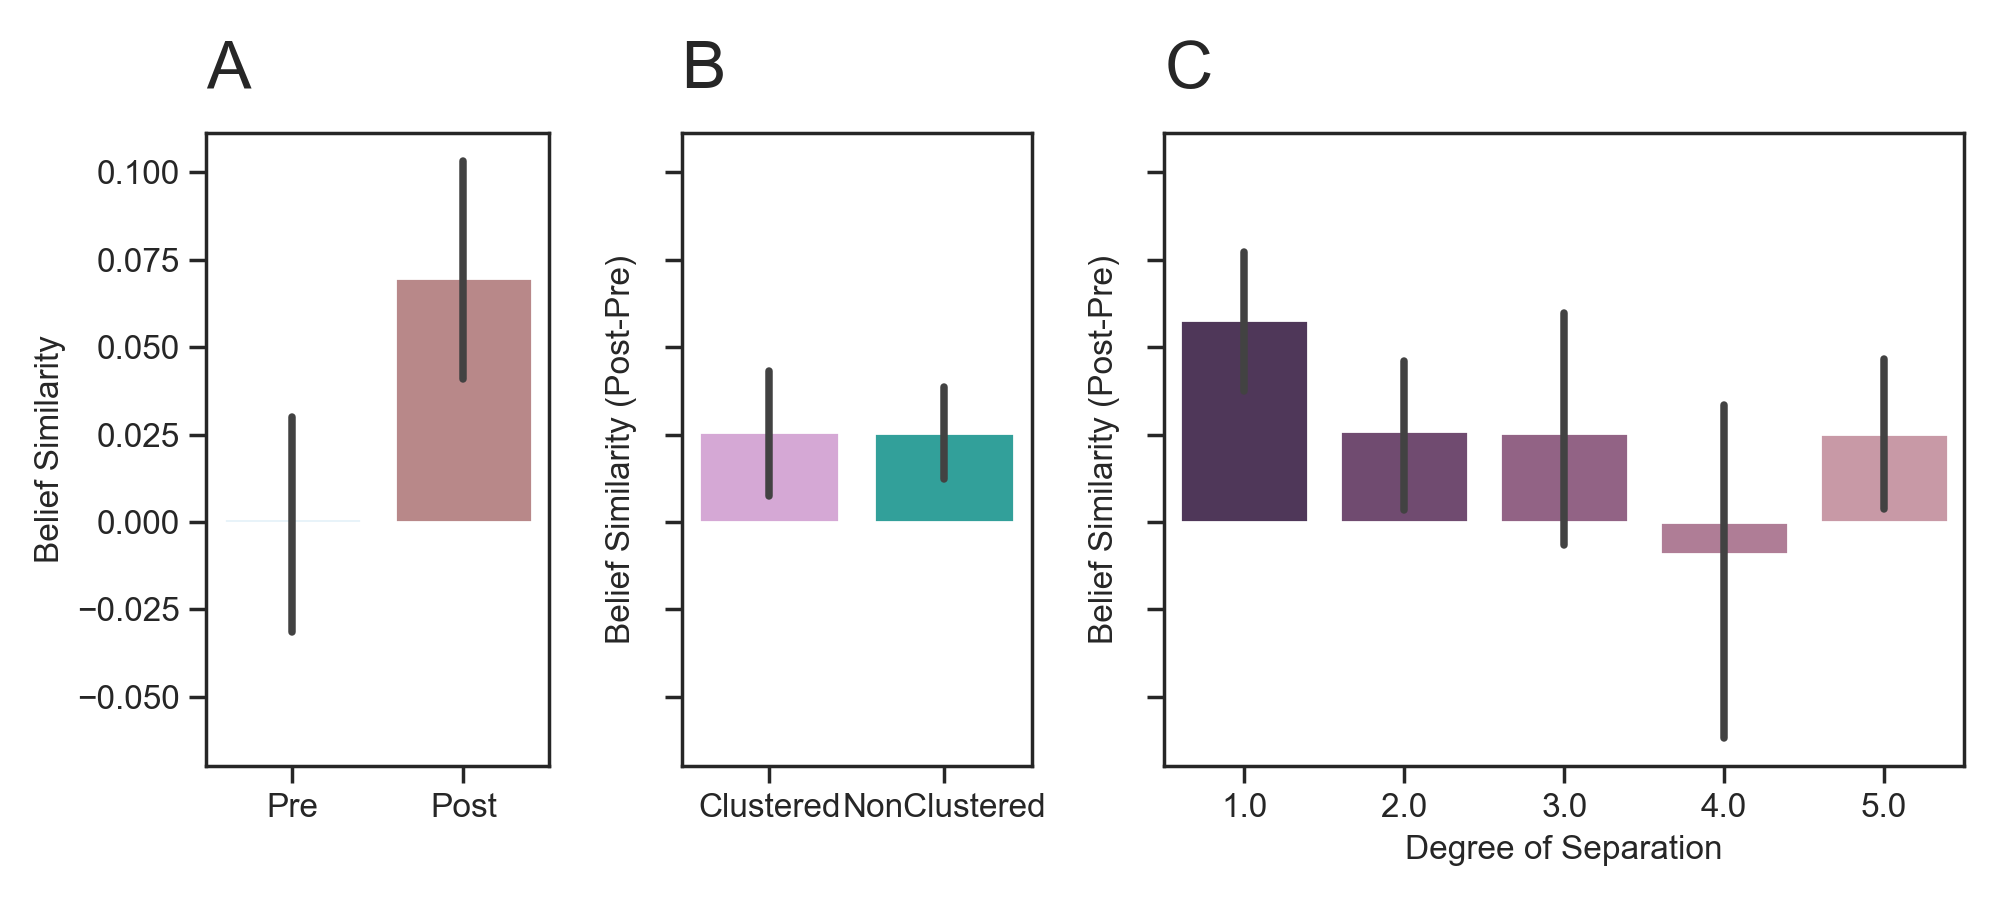

In [47]:
nbin = 20
palll=sns.cubehelix_palette(8, reverse=True)
clustered = np.array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], dtype=np.int)

## PRE
corrs_pre = np.array([])
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "PRE1":"PRE8"])
    iu = iu_cl if clustered[i]>0.5 else iu_nl
#     iu = np.triu_indices(net.shape[0], 1)
#     corrs_pre = np.append(corrs_pre, np.corrcoef(net)[iu])
    corrs_pre = np.append(corrs_pre, stats.spearmanr(net.T).correlation[iu])

## POST
corrs_post = np.array([])
for i in range(max(df["NETWORK"])):
    net = np.array(df.loc[df["NETWORK"]==i+1, "POST1":"POST8"])
    iu = iu_cl if clustered[i]>0.5 else iu_nl    
#     iu = np.triu_indices(net.shape[0], 1)
#     corrs_post = np.append(corrs_post, np.corrcoef(net)[iu])
    corrs_post = np.append(corrs_post, stats.spearmanr(net.T).correlation[iu])
    
fig, ax = plt.subplots(1,3, figsize=(10,4.5), gridspec_kw={"width_ratios": [0.9,0.92,2.1]}, sharey=True)
    
xx = np.hstack([np.ones(corrs_pre.shape), 1+np.ones(corrs_post.shape)])
yy = np.hstack([corrs_pre, corrs_post])
pp = ["#12a1eb","#c08081"]
sns.barplot(xx, yy, palette=pp, ax=ax[0])
ax[0].set_xticklabels(["Pre","Post"])
ax[0].set_ylabel('Belief Similarity')
#ax[0].set_ylim([-0.03,0.11])
bff.panellabel(ax[0], "A")


xxx = np.hstack([np.ones(cdiff_clustered.reshape(-1).shape), 1+np.ones(cdiff_nonclustered.reshape(-1).shape)])
yyy = np.hstack([cdiff_clustered.reshape(-1), cdiff_nonclustered.reshape(-1)])
p = ["#DDA0DD", "#20B2AA"]
sns.barplot(pd.Series(xxx), pd.Series(yyy), palette=p, ax=ax[1])
ax[1].set_xticklabels(["Clustered","NonClustered"])
ax[1].set_ylabel('Belief Similarity (Post-Pre)', labelpad=16)
#ax[1].set_ylim([0,0.055])
bff.panellabel(ax[1], "B")


H_both = np.concatenate((H_clustered_legal.reshape(-1), H_nonclustered_legal.reshape(-1)))
cdiff_both = np.concatenate((cdiff_clustered.reshape(-1), cdiff_nonclustered.reshape(-1)))
# pd.DataFrame(np.vstack((H_both, cdiff_both)).T, columns=["H", "cdiff"])
bardf = pd.DataFrame(np.vstack((H_both, cdiff_both)).T, columns=["H", "cdiff"]).dropna()
sns.barplot(bardf["H"], bardf["cdiff"], palette=palll, ax=ax[2])
ax[2].set(xlabel='Degree of Separation')
ax[2].set_xlim([0.5,5.5])
ax[2].set_ylabel('Belief Similarity (Post-Pre)', labelpad=16)
#ax[2].set_ylim([-0.09,0.09])
bff.panellabel(ax[2], "C")

plt.tight_layout()
# plt.savefig('Fig3.tif', dpi=900, format="tiff")

In [37]:
# import re
# clustered_regular_graphs = []

# s = open("10_3_3.txt").read().splitlines()
# newmatrix = True
# for ln in s:
#     if re.search('[0-9] : ', ln) and newmatrix:
#         newmatrix = False
#         # Starting a new adjacency matrix
#         A = np.zeros((10, 10))
#         nodes = list(map(lambda x: int(x)-1, re.findall('[0-9]+', ln)))
#         i_from = nodes[0]
#         for i_to in nodes[1:]:
#             A[i_from, i_to] = 1
#     elif re.search('[0-9] : ', ln) and not newmatrix:
#         # Continuing an in-progress adjacency matrix
#         nodes = list(map(lambda x: int(x)-1, re.findall('[0-9]+', ln)))
#         i_from = nodes[0]
#         for i_to in nodes[1:]:
#             A[i_from, i_to] = 1
#     elif not re.search('[0-9] : ', ln) and not newmatrix:
#         # Finishing an adjacency matrix
#         clustered_regular_graphs.append(A)
#         newmatrix = True
#     else:
#         # Blank line
#         pass

<IPython.core.display.Javascript object>


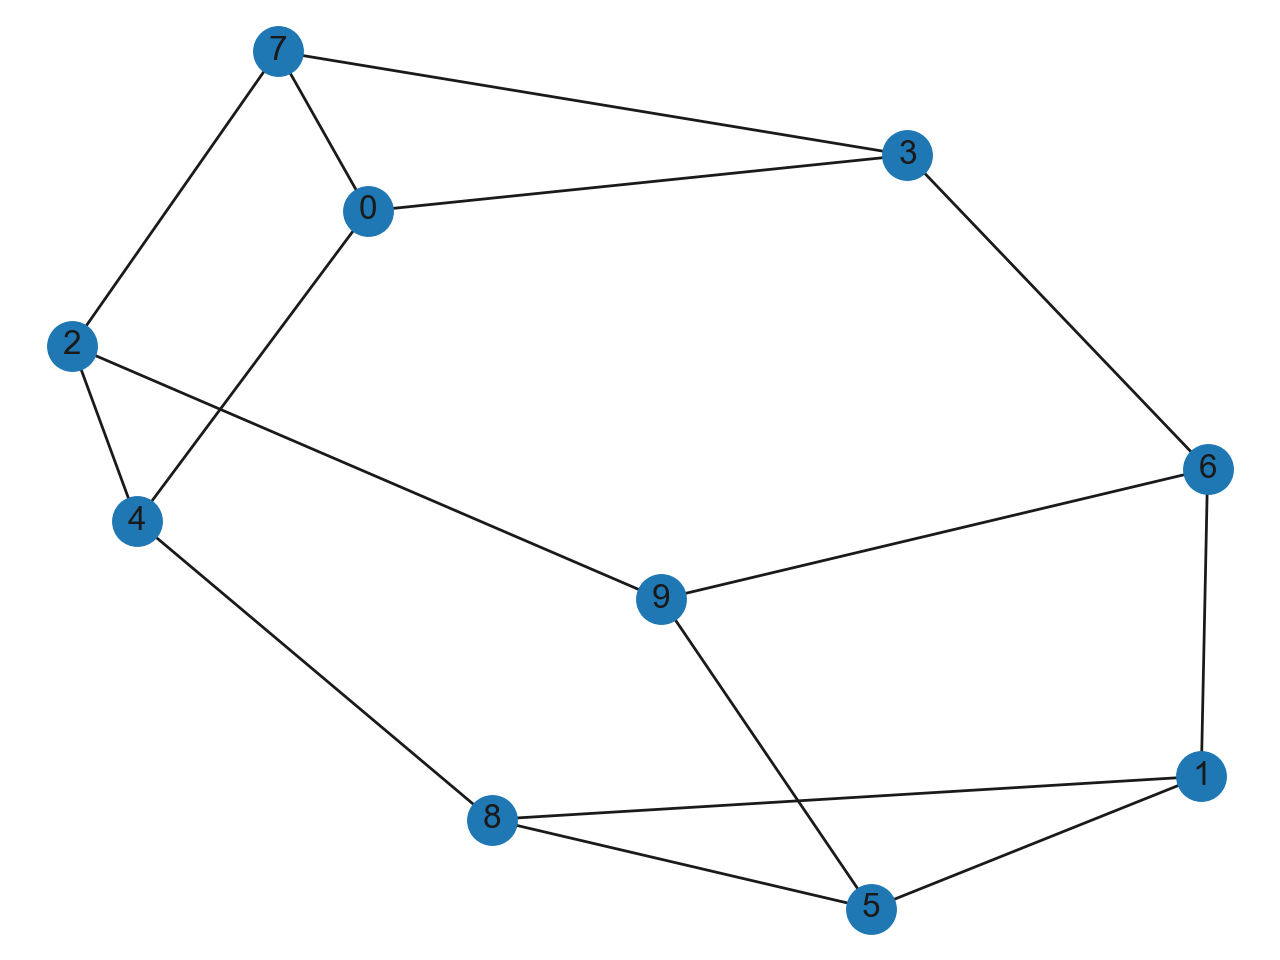

{0: Text(-0.23986015521365817, 0.6326849016690927, '0'),
 1: Text(0.5547176731541081, -0.6692544818390944, '1'),
 2: Text(-0.521786751079078, 0.32253934566991754, '2'),
 3: Text(0.274480904123026, 0.7611734314322375, '3'),
 4: Text(-0.4602729279139819, -0.0816181022345421, '4'),
 5: Text(0.2399547006668432, -0.9737144466593827, '5'),
 6: Text(0.560796315751071, 0.038148160147439714, '6'),
 7: Text(-0.32572013281600865, 1.0, '7'),
 8: Text(-0.12208683505093659, -0.7686919281679927, '8'),
 9: Text(0.03977720837861437, -0.2612668800176748, '9')}

In [46]:
# # Select random adjacency matrix
# A = clustered_regular_graphs[np.random.randint(19)]
# # Randomly permute rows and columns
# perm = np.random.permutation(10)
# A = A[perm,:]
# A = A[:,perm]
# # Adjacency -> networkx graph
# G = nx.from_numpy_matrix(A)

# plt.figure()
# pos = nx.spring_layout(G)
# nx.draw(G, pos=pos)
# nx.draw_networkx_labels(G, pos=pos)

<IPython.core.display.Javascript object>


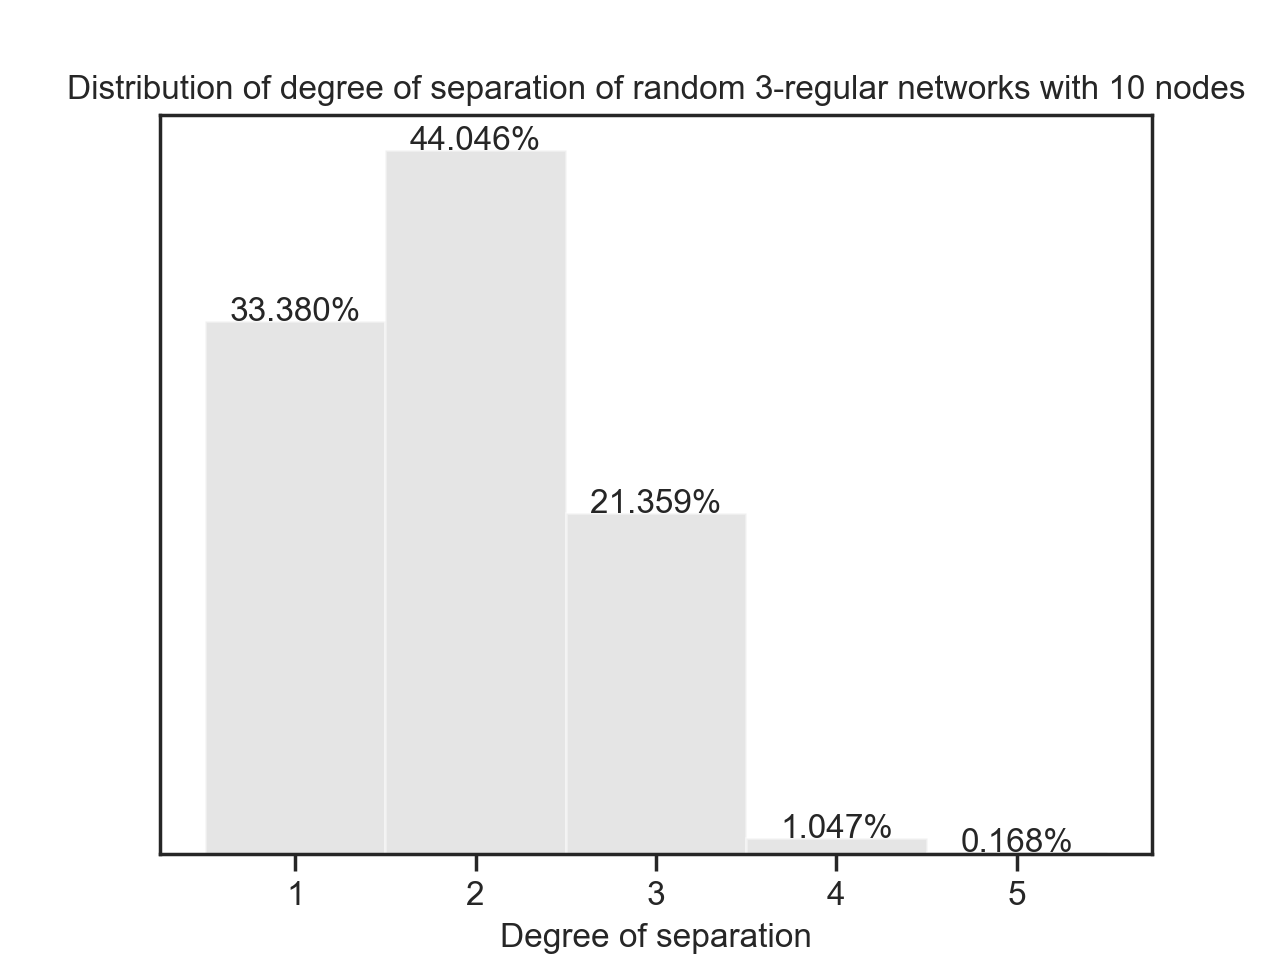

([], <a list of 0 Text yticklabel objects>)

In [95]:
randdists = np.array([])
for _ in range(10000):
    try:
        H = random_network()
        randdists = np.hstack((randdists, H[iu]))
    except:
        pass
    
plt.figure()
ax = sns.distplot(randdists, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], kde=False, norm_hist=True, color="#c0c0c0")
#ax = sns.barplot(x="class", hue="who", data=titanic)
# ax = sns.countplot(x="class", hue="who", data=titanic) # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.3f}%'.format(100*height),
            ha="center") 
plt.title("Distribution of degree of separation of random 3-regular networks with 10 nodes")
plt.xlabel("Degree of separation")
plt.yticks([])

In [79]:
cc = []
for _ in range(10000):
    try:
        ## Generate random d-regular graph on N nodes
        G = nx.random_regular_graph(d, N)
        ## Get shortest path between all pairs of nodes
        path = np.array([len(nx.dijkstra_path(G, i, j))-1 for i in range(1,N) for j in range(i)])
        cc.append(nx.algorithms.cluster.average_clustering(G))
    except:
        pass
cc = np.round(cc, 1)

<IPython.core.display.Javascript object>


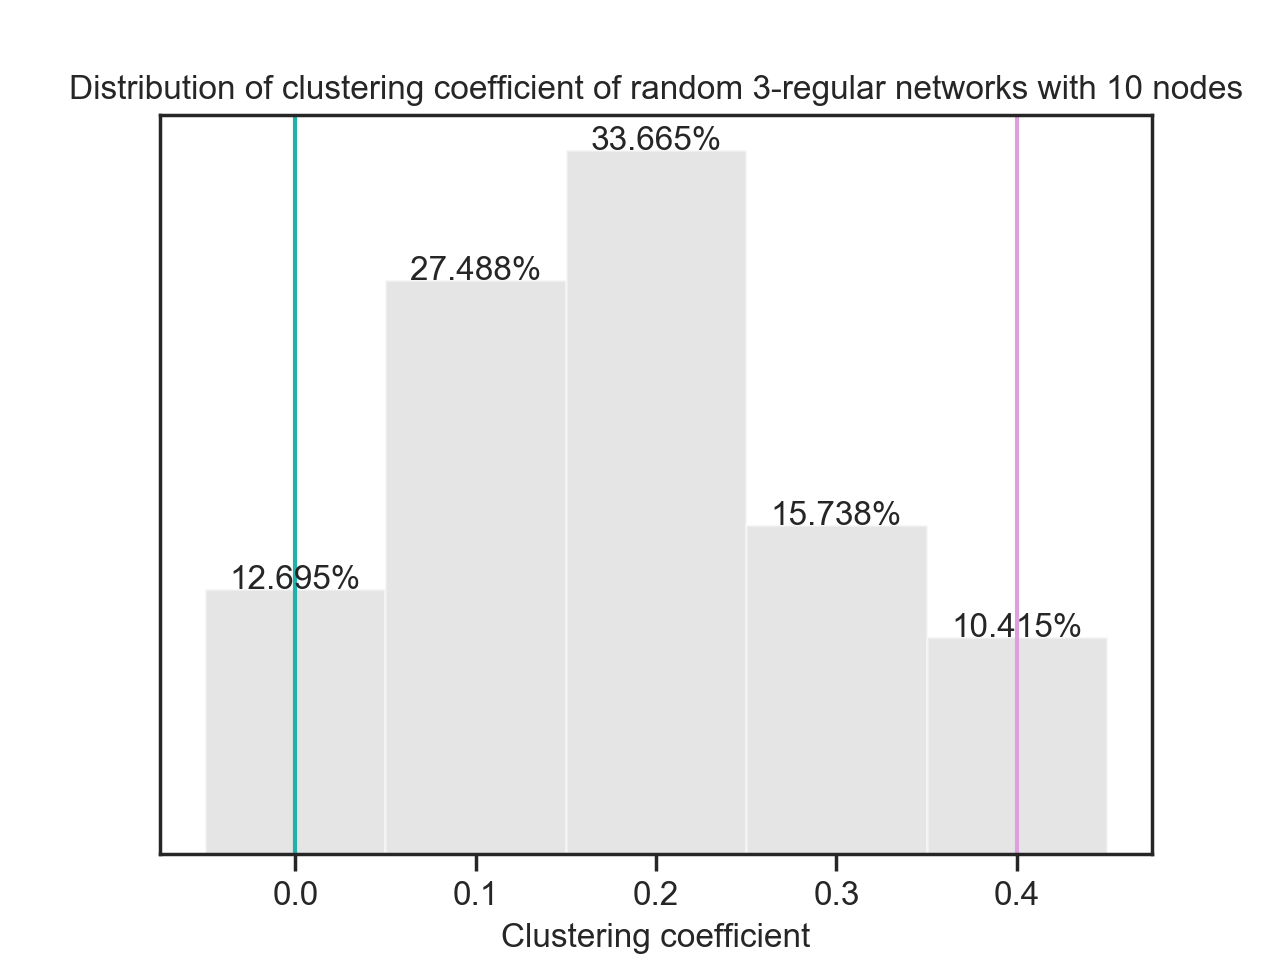

In [94]:
plt.figure()
ax = sns.distplot(cc, bins=[-0.05, 0.05, 0.15, 0.25, 0.35, 0.45], kde=False, color="#c0c0c0")
#ax = sns.barplot(x="class", hue="who", data=titanic)
# ax = sns.countplot(x="class", hue="who", data=titanic) # for Seaborn version 0.7 and more
total = len(cc)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.3f}%'.format(100*height/total),
            ha="center") 
plt.title("Distribution of clustering coefficient of random 3-regular networks with 10 nodes")
plt.xlabel("Clustering coefficient")
# plt.ylabel("Probability")
plt.yticks([])
ax.axvline(0.4, color="#DDA0DD")
ax.axvline(0.0, color="#20B2AA")